In [1]:
import os
import numpy as np
import pickle
from sklearn.cluster import SpectralClustering
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.metrics import f1_score, precision_score, recall_score
import random
import matplotlib.pyplot as plt


In [14]:
def active_learning(material, cube_numbers):
    
    # Function to load dictionary from file
    def load_dictionary(file_path):
        with open(file_path, 'rb') as file:
            return pickle.load(file)

    base_path = f'./Data/Neuchatel_{material}/'
    file_name = f'{material}_feat.pkl'
    file_path = os.path.join(base_path, file_name)

    data_base = load_dictionary(file_path)
    
    # Function to perform initial clustering and training
    def initial_clustering_and_training(data_base, power):
        print(f"Performing initial clustering for power: {power}")
        example = data_base[power]
        algorithm = SpectralClustering(n_clusters=2)
        labels = algorithm.fit_predict(example)
        if labels[0] != 1:
            labels = 1 - labels
        speeds = example[:, -2] * 1800
        power_speed_pairs = np.column_stack((np.full(speeds.shape, power), speeds))
        print(f"Clustering completed for power: {power}")
        return power_speed_pairs, labels

    # Function to train surrogate model using Gaussian Process
    def train_surrogate_model(X, y):
        kernel = C(1.0) * RBF(length_scale=5.0)
        gp_model = GaussianProcessClassifier(kernel=kernel)
        gp_model.fit(X, y)
        print("Gaussian Process model training completed.")
        return gp_model

    # Function to predict labels with uncertainty using GP
    def predict_with_uncertainty(gp_model, X):
        probs = gp_model.predict_proba(X)
        uncertainties = 1 - np.max(probs, axis=1)
        return probs, uncertainties

    # Function to compute evaluation metrics against ground truth
    def compute_metrics(pred_labels, ground_truth):
        gt_labels = ground_truth['Labels']
        precision = precision_score(gt_labels, pred_labels)
        recall = recall_score(gt_labels, pred_labels)
        f1 = f1_score(gt_labels, pred_labels)
        return precision, recall, f1

    # Function to find next power based on uncertainty
    def find_next_power(gp_model, all_powers, explored_powers, speeds):
        unexplored_powers = [p for p in all_powers if p not in explored_powers]
        uncertainties = []

        for power in unexplored_powers:
            test_data = np.array([[power, speed] for speed in speeds])
            _, uncertainty = predict_with_uncertainty(gp_model, test_data)
            uncertainties.append((power, np.mean(uncertainty)))

        next_power = max(uncertainties, key=lambda x: x[1])[0]
        print(f"Next power selected based on uncertainty: {next_power}")
        return next_power

    # Plotting function
    def plot_processing_maps(gt_data, pred_labels, gt_labels, title_pred, title_gt):
        colors_pred = np.where(pred_labels == 1, 'red', 'green')
        colors_gt = np.where(gt_labels == 1, 'red', 'green')
        speeds = gt_data[:, 1]
        powers = gt_data[:, 0]

        fig, axes = plt.subplots(1, 2, figsize=(24, 8))

        # Predictions plot
        axes[0].scatter(speeds, powers, c=colors_pred)
        axes[0].scatter([], [], c='red', label='Keyhole')
        axes[0].scatter([], [], c='green', label='Conduction')
        axes[0].legend(loc='lower right', bbox_to_anchor=(1, 0.2))
        axes[0].set_title(title_pred)
        axes[0].set_xlabel('Speed (mm/s)')
        axes[0].set_ylabel('Power (W)')
        axes[0].grid()
        axes[0].set_xlim(80, 2000)
        axes[0].set_ylim(80, 130)

        # Ground truth plot
        axes[1].scatter(speeds, powers, c=colors_gt)
        axes[1].scatter([], [], c='red', label='Keyhole')
        axes[1].scatter([], [], c='green', label='Conduction')
        axes[1].legend(loc='lower right', bbox_to_anchor=(1, 0.2))
        axes[1].set_title(title_gt)
        axes[1].set_xlabel('Speed (mm/s)')
        axes[1].set_ylabel('Power (W)')
        axes[1].grid()
        axes[1].set_xlim(80, 2000)
        axes[1].set_ylim(80, 130)

        plt.show()

    # Initialize with a random power
    powers = [k for k in data_base.keys() if k != 'GT']
    initial_power = random.choice(powers)
    print(f"Initial power selected: {initial_power}")
    power_speed_pairs, labels = initial_clustering_and_training(data_base, initial_power)

    # Train initial GP model
    gp_model = train_surrogate_model(power_speed_pairs, labels)

    # Predict on all (power, speed) pairs in ground truth
    gt_data = np.array(list(zip(data_base['GT']['Powers'], data_base['GT']['Speeds'])))
    pred_probs, _ = predict_with_uncertainty(gp_model, gt_data)
    pred_labels = np.argmax(pred_probs, axis=1)

    # Initialize metrics storage
    metrics = {
        'experiments': [],
        'precision': [],
        'recall': [],
        'f1_score': []
    }

    # Compute and print initial evaluation metrics
    precision, recall, f1 = compute_metrics(pred_labels, data_base['GT'])
    print(f"Initial Precision: {precision}")
    print(f"Initial Recall: {recall}")
    print(f"Initial F1-score: {f1}")
    print(f"Number of experiments done so far: {len(labels)}")

    # Store initial metrics
    metrics['experiments'].append(len(labels))
    metrics['precision'].append(precision)
    metrics['recall'].append(recall)
    metrics['f1_score'].append(f1)

    # Plot initial predictions and ground truth side by side
    plot_processing_maps(gt_data, pred_labels, np.array(data_base['GT']['Labels']), 
                         'GP Predictions for All Powers', 'Ground Truth for All Powers')

    # Iterative process to find next power and update model
    explored_powers = [initial_power]
    speeds = data_base['GT']['Speeds']

    while len(explored_powers) < len(powers):
        next_power = find_next_power(gp_model, powers, explored_powers, speeds)
        new_power_speed_pairs, new_labels = initial_clustering_and_training(data_base, next_power)

        # Update training data and retrain GP model
        power_speed_pairs = np.vstack((power_speed_pairs, new_power_speed_pairs))
        labels = np.hstack((labels, new_labels))
        gp_model = train_surrogate_model(power_speed_pairs, labels)

        # Predict on all (power, speed) pairs in ground truth
        pred_probs, _ = predict_with_uncertainty(gp_model, gt_data)
        pred_labels = np.argmax(pred_probs, axis=1)

        # Compute and print evaluation metrics
        precision, recall, f1 = compute_metrics(pred_labels, data_base['GT'])
        print(f"Iteration {len(explored_powers)} - Precision: {precision}, Recall: {recall}, F1-score: {f1}")
        print(f"Number of experiments done so far: {len(labels)}")

        # Store metrics
        metrics['experiments'].append(len(labels))
        metrics['precision'].append(precision)
        metrics['recall'].append(recall)
        metrics['f1_score'].append(f1)

        # Plot predictions and ground truth side by side
        plot_processing_maps(gt_data, pred_labels, np.array(data_base['GT']['Labels']), 
                             'GP Predictions for All Powers', 'Ground Truth for All Powers')

        explored_powers.append(next_power)

    # Plot the evolution of metrics
    plt.figure(figsize=(12, 6))
    plt.plot(metrics['experiments'], metrics['precision'], label='Precision', marker='o')
    plt.plot(metrics['experiments'], metrics['recall'], label='Recall', marker='o')
    plt.plot(metrics['experiments'], metrics['f1_score'], label='F1-score', marker='o')
    plt.xlabel('Number of Experiments')
    plt.ylabel('Metric Value')
    plt.title('Evolution of Precision, Recall, and F1-score')
    plt.legend()
    plt.grid()
    plt.show()


Initial power selected: 105
Performing initial clustering for power: 105
Clustering completed for power: 105
Gaussian Process model training completed.
Initial Precision: 0.8888888888888888
Initial Recall: 1.0
Initial F1-score: 0.9411764705882353
Number of experiments done so far: 7


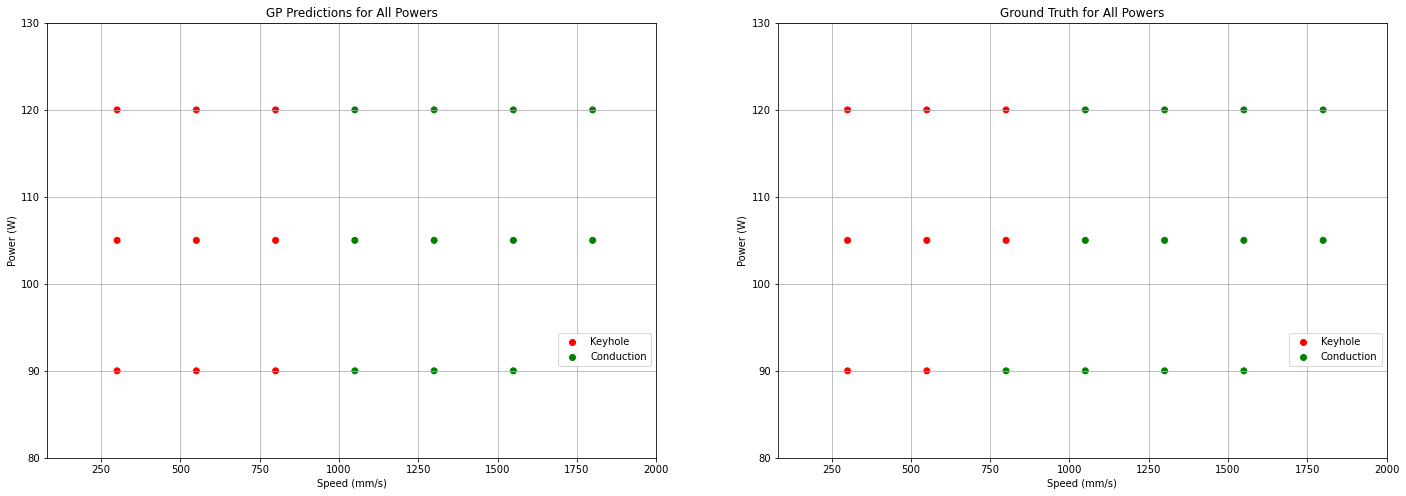

Next power selected based on uncertainty: 120
Performing initial clustering for power: 120
Clustering completed for power: 120
Gaussian Process model training completed.
Iteration 1 - Precision: 0.8888888888888888, Recall: 1.0, F1-score: 0.9411764705882353
Number of experiments done so far: 14


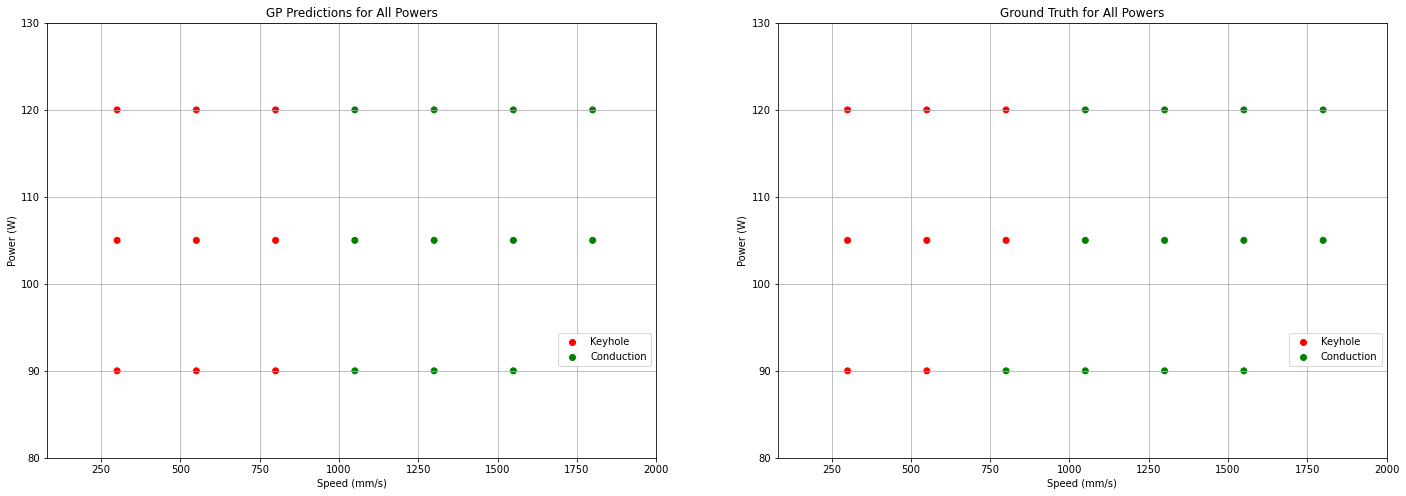

Next power selected based on uncertainty: 90
Performing initial clustering for power: 90
Clustering completed for power: 90
Gaussian Process model training completed.
Iteration 2 - Precision: 0.8888888888888888, Recall: 1.0, F1-score: 0.9411764705882353
Number of experiments done so far: 20


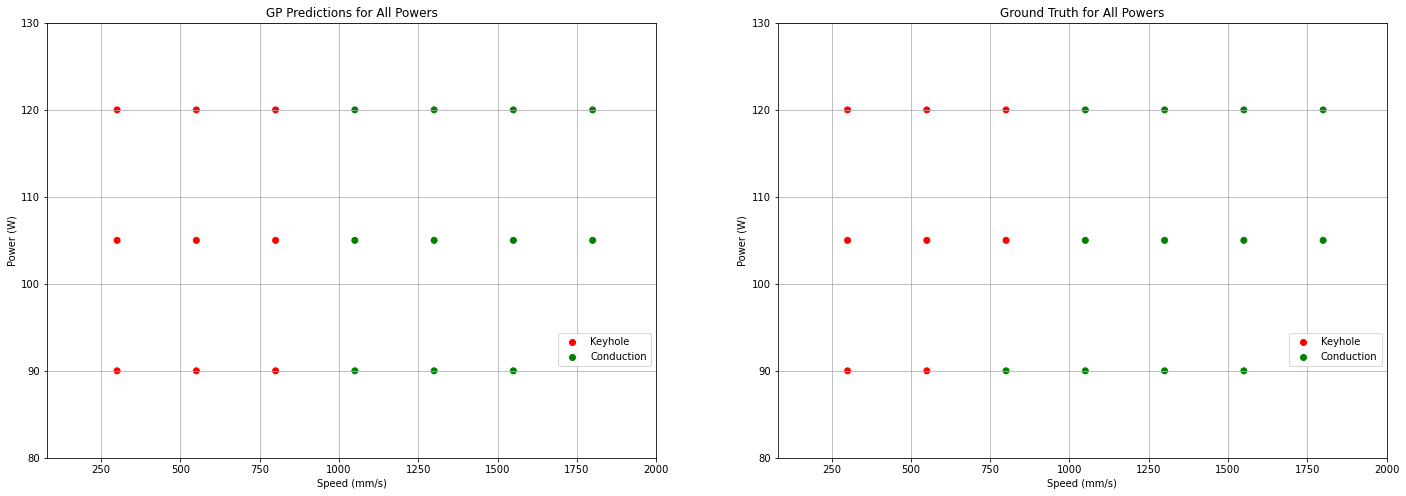

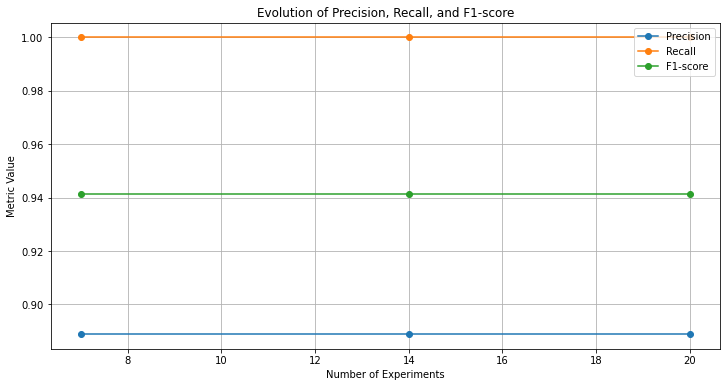

In [15]:
# Load the data
material = '316L'
cube_numbers = [3, 4]

active_learning(material, cube_numbers)

Initial power selected: 120
Performing initial clustering for power: 120
Clustering completed for power: 120
Gaussian Process model training completed.
Initial Precision: 0.75
Initial Recall: 0.75
Initial F1-score: 0.75
Number of experiments done so far: 7


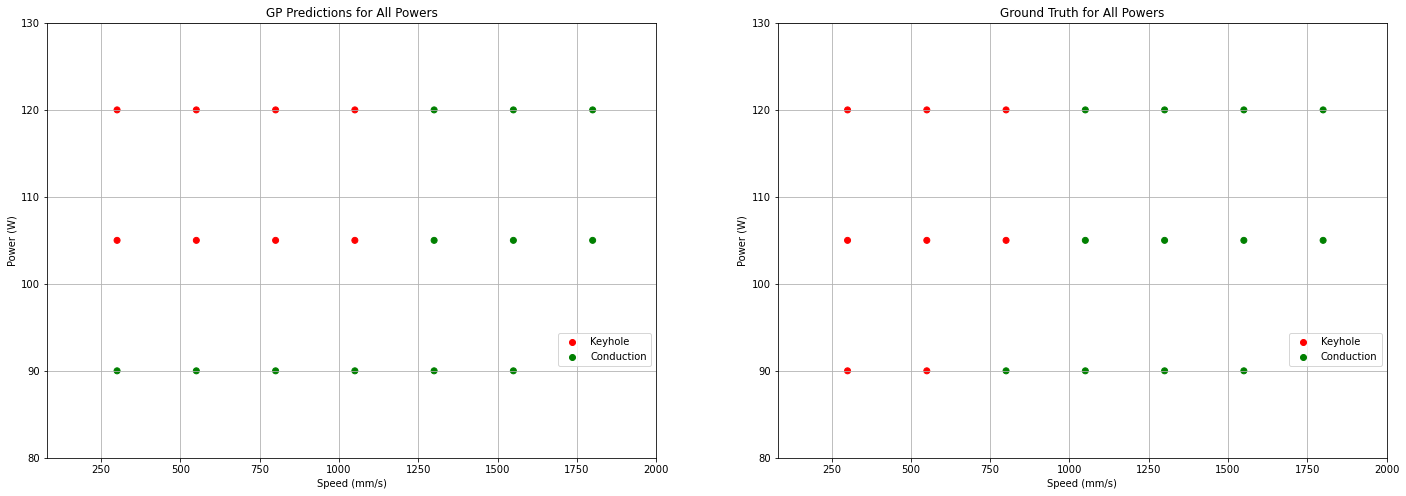

Next power selected based on uncertainty: 90
Performing initial clustering for power: 90
Clustering completed for power: 90
Gaussian Process model training completed.
Iteration 1 - Precision: 0.875, Recall: 0.875, F1-score: 0.875
Number of experiments done so far: 13


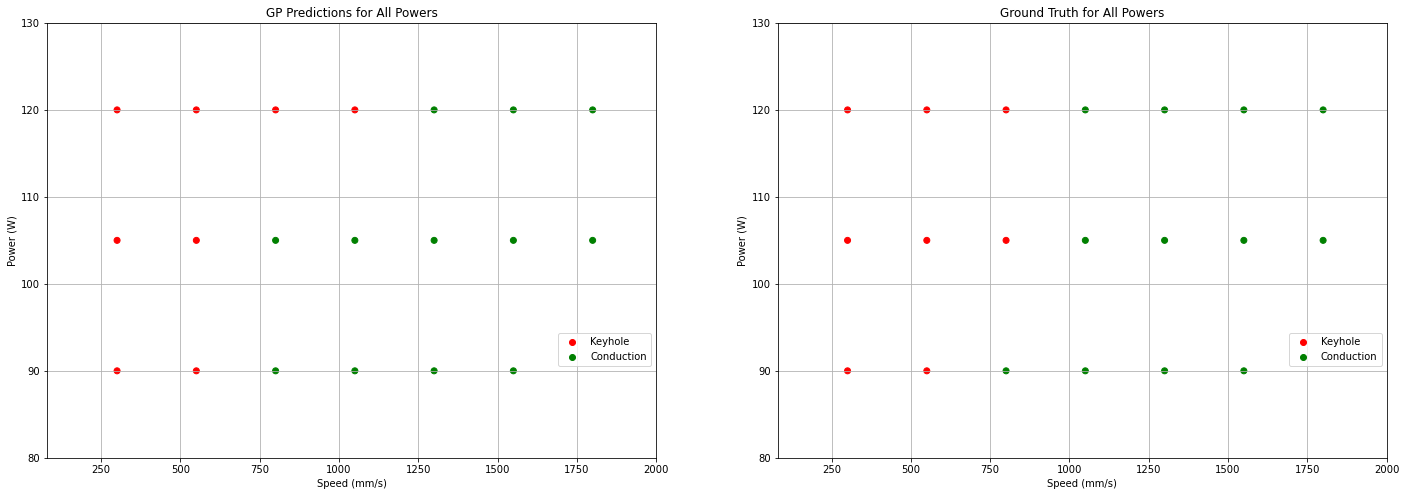

Next power selected based on uncertainty: 105
Performing initial clustering for power: 105
Clustering completed for power: 105
Gaussian Process model training completed.
Iteration 2 - Precision: 0.8888888888888888, Recall: 1.0, F1-score: 0.9411764705882353
Number of experiments done so far: 20


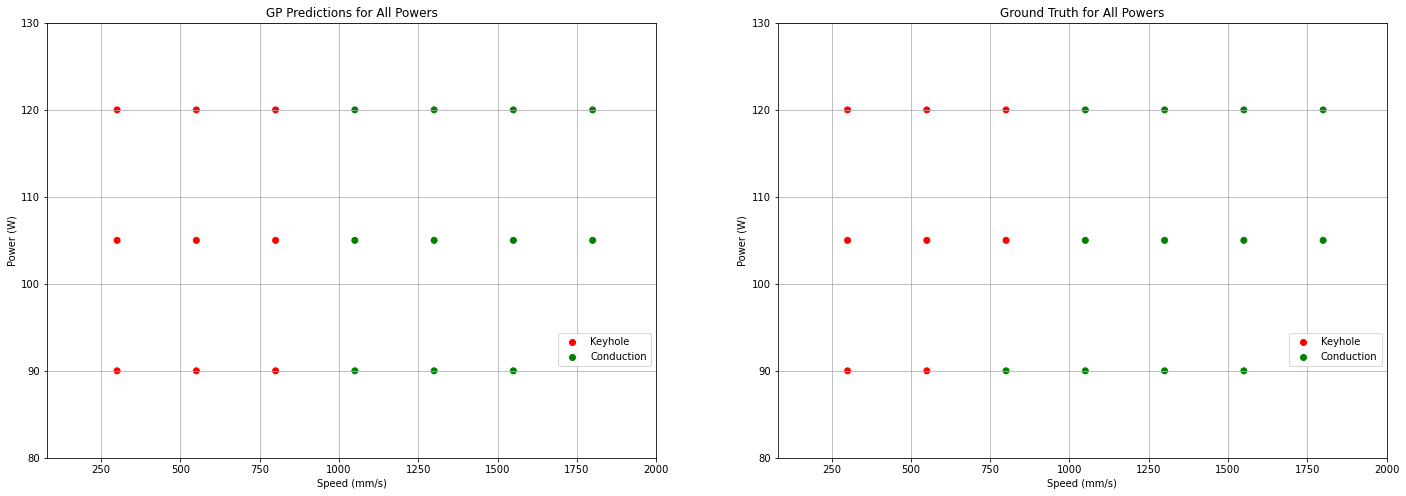

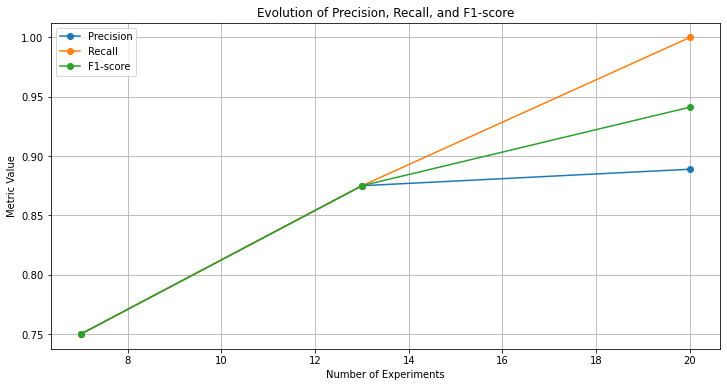

In [16]:
# Load the data
material = 'Ti64'
cube_numbers = [3, 4]

active_learning(material, cube_numbers)